# Example block-wise adaptation using OTDA and BOTDA

In [31]:
import numpy as np # always need it
from numpy import unravel_index
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import ot
import scipy.io
import mne          
from mne.decoding import CSP
mne.set_log_level(verbose='warning') #to avoid info at terminal
import matplotlib.pyplot as pl
from MIOTDAfunctions import*

In [4]:
results_acc=[]
results_all=[]
results_all_inv=[]

rango_cl=[0.1, 1, 10]
rango_e=[0.1, 1, 10] 

## load data at filter it

In [6]:
fName = 'Data/DataSession1_S1.mat'
s = scipy.io.loadmat(fName)

Data_S1=s["X"]
Labels_S1=s["y"]
Labels_S1=np.squeeze(Labels_S1)

#filterting with mne
[nt, nc, ns]=np.shape(Data_S1)
Data_S1=np.reshape(Data_S1, [nt, nc*ns])
Data_S1=mne.filter.filter_data(Data_S1, 128, 8, 30)
Data_S1=np.reshape(Data_S1, [nt,nc,ns])

fName = 'Data/DataSession2_S1.mat'
s2 = scipy.io.loadmat(fName)

Data_S2=s2["X"]
Labels_S2=s2["y"]
Labels_S2=np.squeeze(Labels_S2)

#filterting with mne
[nt, nc, ns]=np.shape(Data_S2)
Data_S2=np.reshape(Data_S2, [nt, nc*ns])
Data_S2=mne.filter.filter_data(Data_S2, 128, 8, 30)
Data_S2=np.reshape(Data_S2, [nt,nc,ns])

### learn CSP+LDA from source data (Data_S1)

In [7]:
Xtr=Data_S1
Ytr=Labels_S1
csp = CSP(n_components=6, reg='empirical', log=True, norm_trace=False, cov_est='epoch')
#learn csp filters
Gtr=csp.fit_transform(Xtr,Ytr)
#learn lda
lda = LinearDiscriminantAnalysis()
lda.fit(Gtr,Ytr)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [34]:
for re in range(0,7):
    print('Running testing RUN={:1.0f}'.format(re))
    #testing run
    Xte=Data_S2[0+20*(re+1):20*(re+1)+20]
    Yte=Labels_S2[0+20*(re+1):20*(re+1)+20]
    #training set-prior data
    Xval=Data_S2[0:20*re+20]
    Yval=Labels_S2[0:20*re+20]
    
    #feature computation
    Gval=csp.transform(Xval)
    Gte=csp.transform(Xte)
    
    #evaluate CNDA  
    acc_cnda=lda.score(Gte, Yte)

    #evaluate RNDA
    Xtr2add=Data_S2[0:20*re+20]
    Ytr2add=Labels_S2[0:20*re+20]
    Xtr2=np.vstack(((Xtr, Xtr2add)))
    Ytr2=np.hstack(((Ytr, Ytr2add)))
        
    Ytr2=Ytr2[len(Ytr2add):]
    Xtr2=Xtr2[len(Ytr2add):]

    csp2 = CSP(n_components=6, reg='empirical', log=True, norm_trace=False, cov_est='epoch')
    #learn csp filters
    Gtr2=csp2.fit_transform(Xtr2,Ytr2)
    #learn lda
    lda2 = LinearDiscriminantAnalysis()
    lda2.fit(Gtr2,Ytr2)

    Gte2=csp2.transform(Xte)
    Gval2=csp2.transform(Xval)
    #ldatest
    acc_rnda=lda2.score(Gte2, Yte)


    M=20
    if len(Yval)>40:
        M=40
    if len(Yval)>80:
        M=80
    
    #%% # Sinkhorn Transport
    # Subset selection re-training path
    G_OTDAs_retr, Y_OTDAs_retr, regu_OTDAs_retr=\
    SelectSubsetTraining_OTDAs(xs=Gtr, ys=Ytr, xv=Gval, yv=Yval, rango_e=rango_e, metrica="euclidean", kfold=20, M=M, trad=True)

    Gtr_daot=G_OTDAs_retr
    Ytr_daot=Y_OTDAs_retr 
    ot_sinkhorn= ot.da.SinkhornTransport(metric="euclidean",reg_e=rango_e[regu_OTDAs_retr])
    #learn the map
    ot_sinkhorn.fit(Xs=Gtr_daot, ys=Ytr_daot, Xt=Gval)
    #apply the mapping over source data
    transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=Gtr)

    # retraining
    lda3 = LinearDiscriminantAnalysis()
    lda3.fit(transp_Xs_sinkhorn,Ytr)
    # Compute acc
    yt_predict_retr1=lda3.predict(Gte)
    acc_otdas_retr=accuracy_score(Yte, yt_predict_retr1)
    
    # Subset selection one-training path
    G_OTDAs_onetr, Y_OTDAs_onetr, regu_OTDAs_onetr=\
    SelectSubsetTraining_OTDAs(xs=Gtr, ys=Ytr, xv=Gval, yv=Yval, rango_e=rango_e, metrica="euclidean", kfold=20, M=M, trad=False)
    
    Gtr_daot=G_OTDAs_onetr
    Ytr_daot=Y_OTDAs_onetr
    ot_sinkhorn= ot.da.SinkhornTransport(metric="euclidean",reg_e=rango_e[regu_OTDAs_onetr])
    #learn the map
    ot_sinkhorn.fit(Xs=Gtr_daot, ys=Ytr_daot, Xt=Gval)
    #apply the mapping over the current testing run
    transp_Xt_sinkhorn = ot_sinkhorn.inverse_transform(Xt=Gte)        

    # Compute accuracy transformed testing data over LDA classifier trained with source data
    yt_predict_onetr1=lda.predict(transp_Xt_sinkhorn)
    acc_otdas_onetr=accuracy_score(Yte, yt_predict_onetr1)
    
    #%% # Group-Lasso Transport
    # Subset selection re-training path
    G_OTDAl1l2_retr, Y_OTDAl1l2_retr, regu_OTDAl1l2_retr=\
    SelectSubsetTraining_OTDAl1l2(xs=Gtr, ys=Ytr, xv=Gval, yv=Yval, rango_e=rango_e, rango_cl=rango_cl, metrica="euclidean", kfold=20, M=M, trad=True)

    Gtr_daot=G_OTDAl1l2_retr
    Ytr_daot=Y_OTDAl1l2_retr
    
    ot_l1l2 = ot.da.SinkhornL1l2Transport(metric="euclidean",reg_e=rango_e[regu_OTDAl1l2_retr[0]], reg_cl=rango_cl[regu_OTDAl1l2_retr[1]])

    ot_l1l2.fit(Xs=Gtr_daot, ys=Ytr_daot, Xt=Gval)

    #transport taget samples onto source samples
    transp_Xs_l1l2=ot_l1l2.transform(Xs=Gtr)

    # retraining
    lda3 = LinearDiscriminantAnalysis()
    lda3.fit(transp_Xs_l1l2,Ytr)

    # Compute acc
    yt_predict_retr2=lda3.predict(Gte)
    acc_otdal1l2_retr=accuracy_score(Yte, yt_predict_retr2)
    
    # Subset selection one-training path

    G_OTDAl1l2_onetr, Y_OTDAl1l2_onetr, regu_OTDAl1l2_onetr=\
    SelectSubsetTraining_OTDAl1l2(xs=Gtr, ys=Ytr, xv=Gval, yv=Yval, rango_e=rango_e, rango_cl=rango_cl, metrica="euclidean", kfold=20, M=M, trad=False)

    Gtr_daot=G_OTDAl1l2_onetr
    Ytr_daot=Y_OTDAl1l2_onetr
    
    ot_l1l2 = ot.da.SinkhornL1l2Transport(metric="euclidean",reg_e=rango_e[regu_OTDAl1l2_onetr[0]], reg_cl=rango_cl[regu_OTDAl1l2_onetr[1]])

    ot_l1l2.fit(Xs=Gtr_daot, ys=Ytr_daot, Xt=Gval)

    #transport taget samples onto source samples
    transp_Xt_l1l2=ot_l1l2.inverse_transform(Xt=Gte)        
    # Compute accuracy inverse DAOT   
    yt_predict_onetr2=lda.predict(transp_Xt_l1l2)
    acc_otdal1l2_onetr=accuracy_score(Yte, yt_predict_onetr2)
    
    #%% # Backward Sinkhorn Transport
    # Subset selection re-training path
    G_BOTDAs_retr, Y_BOTDAs_retr, regu_BOTDAs_retr=\
    SelectSubsetTraining_BOTDAs(xs=Gtr, ys=Ytr, xv=Gval, yv=Yval, rango_e=rango_e, metrica="euclidean", kfold=20, M=M, trad=True)

    Gtr_botda=G_BOTDAs_retr
    Ytr_botda=Y_BOTDAs_retr
    
    bot_s= ot.da.SinkhornTransport(metric="euclidean",reg_e=rango_e[regu_BOTDAs_retr])

    bot_s.fit(Xs=Gval, ys=Yval, Xt=Gtr_botda, yt=Ytr_botda)
    
    #transport source samples onto target source

    transp_Xs_s_backward=bot_s.inverse_transform(Xt=Gtr)

    # retraining
    lda3 = LinearDiscriminantAnalysis()
    lda3.fit(transp_Xs_s_backward,Ytr)

    # Compute acc
    yt_predict_retr3=lda3.predict(Gte)
    acc_botdas_retr=accuracy_score(Yte, yt_predict_retr3)
    
    # Subset selection one-training path
    G_BOTDAs_onetr, Y_BOTDAs_onetr, regu_BOTDAs_onetr=\
    SelectSubsetTraining_BOTDAs(xs=Gtr, ys=Ytr, xv=Gval, yv=Yval, rango_e=rango_e, metrica="euclidean", kfold=20, M=M, trad=False)

    Gtr_botda=G_BOTDAs_onetr
    Ytr_botda=Y_BOTDAs_onetr
    
    bot_s = ot.da.SinkhornTransport(metric="euclidean",reg_e=rango_e[regu_BOTDAs_onetr])
    
    
    bot_s.fit(Xs=Gval, ys=Yval, Xt=Gtr_botda, yt=Ytr_botda)
    #transport testing samples
    transp_Xt_s_backward=bot_s.transform(Xs=Gte)
    # Compute accuracy one-training    
    yt_predict_onetr3=lda.predict(transp_Xt_s_backward)
    acc_botdas_onetr=accuracy_score(Yte, yt_predict_onetr3)
    
    #%% # Backward Group-Lasso Transport
    # Subset selection re-training path
    G_BOTDAl1l2_retr, Y_BOTDAl1l2_retr, regu_BOTDAl1l2_retr=\
    SelectSubsetTraining_BOTDAl1l2(xs=Gtr, ys=Ytr, xv=Gval, yv=Yval, rango_e=rango_e, rango_cl=rango_cl, metrica="euclidean", kfold=20, M=M, trad=True)

    Gtr_botda=G_BOTDAl1l2_retr
    Ytr_botda=Y_BOTDAl1l2_retr
    
    bot_l1l2 = ot.da.SinkhornL1l2Transport(metric="euclidean",reg_e=rango_e[regu_BOTDAl1l2_retr[0]], reg_cl=rango_cl[regu_BOTDAl1l2_retr[1]])

    bot_l1l2.fit(Xs=Gval, ys=Yval, Xt=Gtr_botda, yt=Ytr_botda)
    
    #transport source samples onto target source

    transp_Xs_l1l2_backward=bot_l1l2.inverse_transform(Xt=Gtr)

    # retraining
    lda3 = LinearDiscriminantAnalysis()
    lda3.fit(transp_Xs_l1l2_backward,Ytr)

    # Compute acc
    yt_predict_retr4=lda3.predict(Gte)
    acc_botdal1l2_retr=accuracy_score(Yte, yt_predict_retr4)
    
    # Subset selection one-training path
    G_BOTDAl1l2_onetr, Y_BOTDAl1l2_onetr, regu_BOTDAl1l2_onetr=\
    SelectSubsetTraining_BOTDAl1l2(xs=Gtr, ys=Ytr, xv=Gval, yv=Yval, rango_e=rango_e, rango_cl=rango_cl, metrica="euclidean", kfold=20, M=M, trad=False)

    Gtr_botda=G_BOTDAl1l2_onetr
    Ytr_botda=Y_BOTDAl1l2_onetr
    
    bot_l1l2 = ot.da.SinkhornL1l2Transport(metric="euclidean",reg_e=rango_e[regu_BOTDAl1l2_onetr[0]], reg_cl=rango_cl[regu_BOTDAl1l2_onetr[1]])
    
    
    bot_l1l2.fit(Xs=Gval, ys=Yval, Xt=Gtr_botda, yt=Ytr_botda)
    #transport testing samples
    transp_Xt_l1l2_backward=bot_l1l2.transform(Xs=Gte)
    # Compute accuracy one-training    
    yt_predict_onetr4=lda.predict(transp_Xt_l1l2_backward)
    acc_botdal1l2_onetr=accuracy_score(Yte, yt_predict_onetr4)
    # print results
    acc={}
    acc["cnda"]=acc_cnda
    acc["rnda"]=acc_rnda
    acc["otdas_retr"]=acc_otdas_retr
    acc["otdas_onetr"]=acc_otdas_onetr
    acc["otdal1l2_retr"]=acc_otdal1l2_retr
    acc["otdal1l2_onetr"]=acc_otdal1l2_onetr
    acc["botdas_retr"]=acc_botdas_retr
    acc["botdas_onetr"]=acc_botdas_onetr
    acc["botdal1l2_retr"]=acc_botdal1l2_retr
    acc["botdal1l2_onetr"]=acc_botdal1l2_onetr
    
    print(acc)  
    

Running testing RUN=0
{'cnda': 0.6, 'rnda': 0.65, 'otdas_retr': 0.65, 'otdas_onetr': 0.7, 'otdal1l2_retr': 0.7, 'otdal1l2_onetr': 0.65, 'botdas_retr': 0.7, 'botdas_onetr': 0.6, 'botdal1l2_retr': 0.6, 'botdal1l2_onetr': 0.6}
Running testing RUN=1
{'cnda': 0.7, 'rnda': 0.65, 'otdas_retr': 0.6, 'otdas_onetr': 0.65, 'otdal1l2_retr': 0.7, 'otdal1l2_onetr': 0.7, 'botdas_retr': 0.7, 'botdas_onetr': 0.6, 'botdal1l2_retr': 0.7, 'botdal1l2_onetr': 0.5}
Running testing RUN=2
{'cnda': 0.85, 'rnda': 0.9, 'otdas_retr': 0.6, 'otdas_onetr': 0.65, 'otdal1l2_retr': 0.8, 'otdal1l2_onetr': 0.75, 'botdas_retr': 0.75, 'botdas_onetr': 0.65, 'botdal1l2_retr': 0.7, 'botdal1l2_onetr': 0.55}
Running testing RUN=3
{'cnda': 0.7, 'rnda': 0.85, 'otdas_retr': 0.7, 'otdas_onetr': 0.75, 'otdal1l2_retr': 0.7, 'otdal1l2_onetr': 0.7, 'botdas_retr': 0.7, 'botdas_onetr': 0.75, 'botdal1l2_retr': 0.75, 'botdal1l2_onetr': 0.7}
Running testing RUN=4
{'cnda': 0.95, 'rnda': 0.9, 'otdas_retr': 0.95, 'otdas_onetr': 0.95, 'otdal1l2_

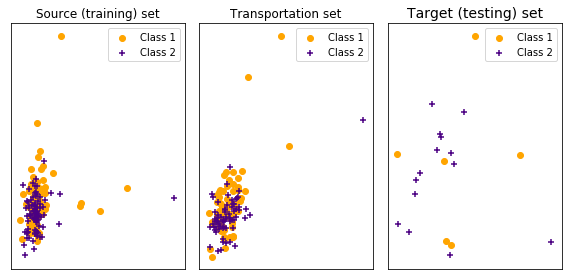

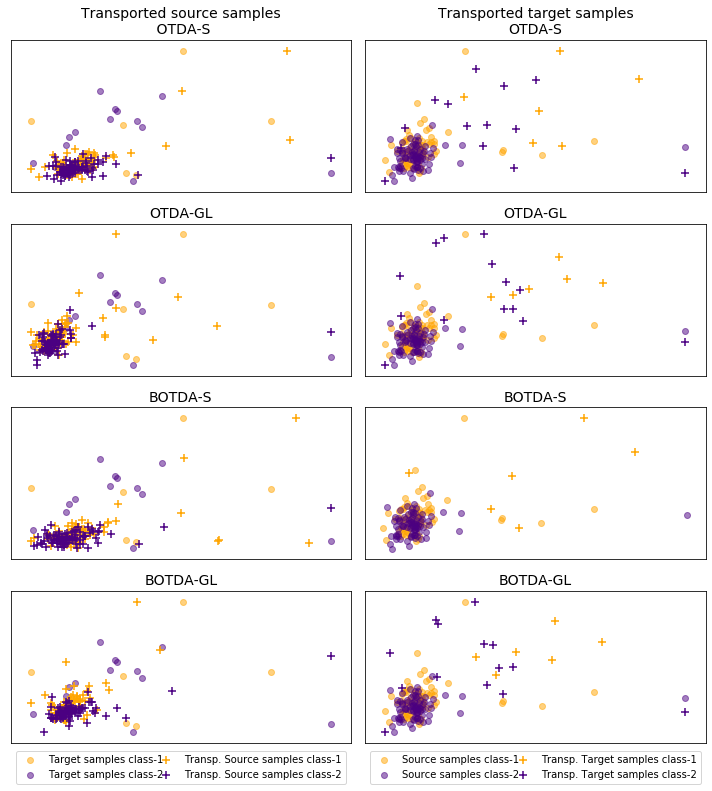

In [35]:
#Plotting-->for the last testing run

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
Gtr_norm = min_max_scaler.fit_transform(Gtr)    
Gte_norm = min_max_scaler.fit_transform(Gte) 
Gval_norm = min_max_scaler.fit_transform(Gval)    

#distribution datasets
pl.figure(figsize=(8, 4))

pl.subplot(1, 3, 1)
pl.scatter(Gtr_norm[Ytr==1, 0], Gtr_norm[Ytr==1, -1], c='orange', marker='o', label='Class 1')
pl.scatter(Gtr_norm[Ytr==2, 0], Gtr_norm[Ytr==2, -1], c='indigo', marker='+', label='Class 2')

pl.xticks([])
pl.yticks([])
pl.legend(loc=1)
pl.title('Source (training) set')

pl.subplot(1, 3, 2)
pl.scatter(Gval_norm[Yval==1, 0], Gval_norm[Yval==1, -1], c='orange', marker='o', label='Class 1')
pl.scatter(Gval_norm[Yval==2, 0], Gval_norm[Yval==2, -1], c='indigo', marker='+', label='Class 2')

pl.xticks([])
pl.yticks([])
pl.legend(loc=1)
pl.title('Transportation set')
pl.tight_layout()

    
pl.subplot(1, 3, 3)
pl.scatter(Gte_norm[Yte==1, 0], Gte_norm[Yte==1, -1], c='orange', marker='o', label='Class 1')
pl.scatter(Gte_norm[Yte==2, 0], Gte_norm[Yte==2, -1], c='indigo', marker='+', label='Class 2')

pl.xticks([])
pl.yticks([])
pl.legend(loc=1)
pl.title('Target (testing) set', size=14 )
pl.tight_layout()

# plotting original and transported samples for eahc method
#%% scalling
transp_Xs_sinkhorn_norm = min_max_scaler.fit_transform(transp_Xs_sinkhorn)    
transp_Xt_sinkhorn_norm = min_max_scaler.fit_transform(transp_Xt_sinkhorn) 
transp_Xs_l1l2_norm = min_max_scaler.fit_transform(transp_Xs_l1l2) 
transp_Xt_l1l2_norm= min_max_scaler.fit_transform(transp_Xt_l1l2) 
transp_Xt_s_B_norm= min_max_scaler.fit_transform(transp_Xt_s_backward) 
transp_Xs_s_B_norm= min_max_scaler.fit_transform(transp_Xs_s_backward)
transp_Xs_l1l2_B_norm= min_max_scaler.fit_transform(transp_Xs_l1l2_backward)
transp_Xt_l1l2_B_norm= min_max_scaler.fit_transform(transp_Xt_l1l2_backward)
pl.figure(figsize=(10, 11))
    
pl.subplot(4, 2, 1)
pl.scatter(Gte_norm[Yte==1, 0], Gte_norm[Yte==1, -1], c='orange', marker='o',
           alpha=0.5)
pl.scatter(Gte_norm[Yte==2, 0], Gte_norm[Yte==2, -1], c='indigo', marker='o',
           alpha=0.5)
pl.scatter(transp_Xs_sinkhorn_norm[Ytr==1, 0], transp_Xs_sinkhorn_norm[Ytr==1, -1], c='orange',
           marker='+', s=50 )
pl.scatter(transp_Xs_sinkhorn_norm[Ytr==2, 0], transp_Xs_sinkhorn_norm[Ytr==2, -1], c='indigo',
           marker='+', s=50 )
pl.title('Transported source samples\n OTDA-S', size=14)
pl.xticks([])
pl.yticks([])

pl.subplot(4, 2, 2)
pl.scatter(Gtr_norm[Ytr==1, 0], Gtr_norm[Ytr==1, -1], c='orange', marker='o',alpha=0.5)
pl.scatter(Gtr_norm[Ytr==2, 0], Gtr_norm[Ytr==2, -1], c='indigo', marker='o',alpha=0.5)

pl.scatter(transp_Xt_sinkhorn_norm[Yte==1, 0], transp_Xt_sinkhorn_norm[Yte==1, -1], c='orange',
            marker='+', s=50)
pl.scatter(transp_Xt_sinkhorn_norm[Yte==2, 0], transp_Xt_sinkhorn_norm[Yte==2, -1], c='indigo',
            marker='+', s=50)
pl.title('Transported target samples\nOTDA-S', size=14)
pl.xticks([])
pl.yticks([])
#l1l2
pl.subplot(4, 2, 3)
pl.scatter(Gte_norm[Yte==1, 0], Gte_norm[Yte==1, -1], c='orange', marker='o',
           alpha=0.5)
pl.scatter(Gte_norm[Yte==2, 0], Gte_norm[Yte==2, -1], c='indigo', marker='o',
           alpha=0.5)
pl.scatter(transp_Xs_l1l2_norm[Ytr==1, 0], transp_Xs_l1l2_norm[Ytr==1, -1], c='orange',
           marker='+', s=50 )
pl.scatter(transp_Xs_l1l2_norm[Ytr==2, 0], transp_Xs_l1l2_norm[Ytr==2, -1], c='indigo',
           marker='+', s=50 )
pl.title('OTDA-GL', size=14)
pl.xticks([])
pl.yticks([])

pl.subplot(4, 2, 4)
pl.scatter(Gtr_norm[Ytr==1, 0], Gtr_norm[Ytr==1, -1], c='orange', marker='o',alpha=0.5)
pl.scatter(Gtr_norm[Ytr==2, 0], Gtr_norm[Ytr==2, -1], c='indigo', marker='o',alpha=0.5)

pl.scatter(transp_Xt_l1l2_norm[Yte==1, 0], transp_Xt_l1l2_norm[Yte==1, -1], c='orange',
            marker='+', s=50)
pl.scatter(transp_Xt_l1l2_norm[Yte==2, 0], transp_Xt_l1l2_norm[Yte==2, -1], c='indigo',
            marker='+', s=50)
pl.title('OTDA-GL', size=14)
pl.xticks([])
pl.yticks([])

#S-B
pl.subplot(4, 2, 5)
pl.scatter(Gte_norm[Yte==1, 0], Gte_norm[Yte==1, -1], c='orange', marker='o',
           alpha=0.5)
pl.scatter(Gte_norm[Yte==2, 0], Gte_norm[Yte==2, -1], c='indigo', marker='o',
           alpha=0.5)
pl.scatter(transp_Xs_s_B_norm[Ytr==1, 0], transp_Xs_s_B_norm[Ytr==1, -1], c='orange',
           marker='+', s=50 )
pl.scatter(transp_Xs_s_B_norm[Ytr==2, 0], transp_Xs_s_B_norm[Ytr==2, -1], c='indigo',
           marker='+', s=50 )
pl.title('BOTDA-S', size=14)
pl.xticks([])
pl.yticks([])

pl.subplot(4, 2, 6)
pl.scatter(Gtr_norm[Ytr==1, 0], Gtr_norm[Ytr==1, -1], c='orange', marker='o',alpha=0.5)
pl.scatter(Gtr_norm[Ytr==2, 0], Gtr_norm[Ytr==2, -1], c='indigo', marker='o',alpha=0.5)

pl.scatter(transp_Xt_s_B_norm[Yte==1, 0], transp_Xt_s_B_norm[Yte==1, -1], c='orange',
            marker='+', s=50)
pl.scatter(transp_Xt_s_B_norm[Yte==2, 0], transp_Xt_s_B_norm[Yte==2, -1], c='indigo',
            marker='+', s=0)
pl.title('BOTDA-S', size=14)
pl.xticks([])
pl.yticks([])

    
#l1l2-B
pl.subplot(4, 2, 7)
pl.scatter(Gte_norm[Yte==1, 0], Gte_norm[Yte==1, -1], c='orange', marker='o',
           alpha=0.5, Label='Target samples class-1')
pl.scatter(Gte_norm[Yte==2, 0], Gte_norm[Yte==2, -1], c='indigo', marker='o',
           alpha=0.5, Label='Target samples class-2')
pl.scatter(transp_Xs_l1l2_B_norm[Ytr==1, 0], transp_Xs_l1l2_B_norm[Ytr==1, -1], c='orange',
           marker='+', s=50, Label='Transp. Source samples class-1' )
pl.scatter(transp_Xs_l1l2_B_norm[Ytr==2, 0], transp_Xs_l1l2_B_norm[Ytr==2, -1], c='indigo',
           marker='+', s=50, Label='Transp. Source samples class-2' )
pl.title('BOTDA-GL', size=14)
pl.legend(loc=8, ncol=2, mode="expand", bbox_to_anchor=(0, -0.3, 1, 0.65))
pl.xticks([])
pl.yticks([])

pl.subplot(4, 2, 8)
pl.scatter(Gtr_norm[Ytr==1, 0], Gtr_norm[Ytr==1, -1], c='orange', marker='o',alpha=0.5, 
           Label='Source samples class-1')
pl.scatter(Gtr_norm[Ytr==2, 0], Gtr_norm[Ytr==2, -1], c='indigo', marker='o',alpha=0.5,
           Label='Source samples class-2')

pl.scatter(transp_Xt_l1l2_B_norm[Yte==1, 0], transp_Xt_l1l2_B_norm[Yte==1, -1], c='orange',
            marker='+', s=50, Label='Transp. Target samples class-1')
pl.scatter(transp_Xt_l1l2_B_norm[Yte==2, 0], transp_Xt_l1l2_B_norm[Yte==2, -1], c='indigo',
            marker='+', s=50, Label='Transp. Target samples class-2')
pl.title('BOTDA-GL', size=14)
pl.legend(loc=8, ncol=2, mode="expand", bbox_to_anchor=(0, -0.3, 1, 0.65))
pl.xticks([])
pl.yticks([])
pl.tight_layout()